# CNN Assignment

In the second assignment for the AIA semester, I aim to deepen my understanding of Convolutional Neural Networks (CNNs) through both theoretical exploration and practical implementation. The study is divided into two parts.

In the first part, I construct a CNN from scratch using NumPy. This approach integrates theoretical concepts with hands-on coding, enabling a detailed examination of the underlying operations such as convolution, activation functions, and pooling mechanisms. This controlled implementation provides a clear view of the mechanics behind CNNs.(I won't provide the complete math block as in the ANN assignment , since most of the theory is the same for both architectures, hence the CNN theory is better to be explained during the implementation as separate md cells above the code cell). Also, I plan to evaluate the results of the CNN on CIFAR10, with respect to the ANN results on the same dataset, in order to justify the CNN usage on computer vision tasks.

The second part utilizes the PyTorch framework to train and evaluate CNN models, I plan to work with train process and hyperparameters to reach state-of-art results on real dataset.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import cupy as cp
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

Auto reload parameter of notebook is useful during development, it allows to access the most recent content of other python files after they were modified, without need to re-run cell where they were imported, significantly boosting the debuging flow.

In [2]:
%load_ext autoreload
%autoreload 2

## Loading the CIFAR10 Dataset

For the initial experiments, I employ the CIFAR10 dataset as it offers a balanced and challenging benchmark for computer vision tasks. The images are preprocessed into a suitable format that aligns with the custom NumPy-based implementation.

Data loaders for training and testing are established with a bigger batch size, ensuring efficient training and evaluation with cuda enabled.


In [96]:
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128

train_subset, _ = random_split(train_dataset, [5000, len(train_dataset) - 5000])
test_subset, _ = random_split(test_dataset, [1000, len(test_dataset) - 1000])

# Create DataLoader with subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Visualizing Samples from CIFAR10

I extract one image per class from the training set and display them side-by-side. This quick visualization confirms that the dataset is loaded correctly and gives an overview of the image categories.


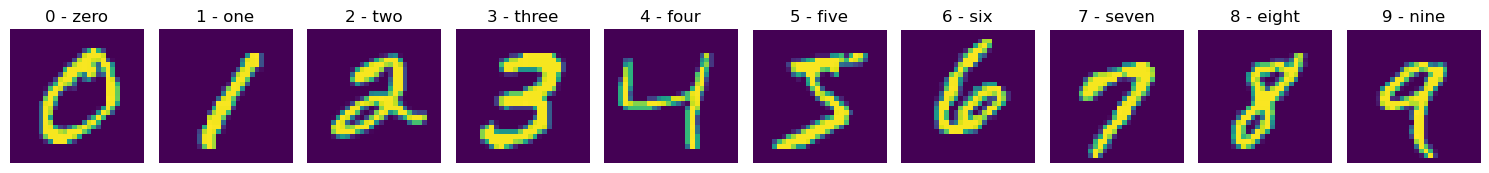

In [4]:
classes = train_dataset.classes

samples = {}
for img, label in train_dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == len(classes):
        break

# Plot the images.
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))
for label, ax in enumerate(axs):
    img_np = samples[label].permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


## Helper Functions and General Layer Implementations

The next code cell includes various helper functions and layer implementations from the previous assignment. This set comprises:

- `softmax`
- `l2_regularization`
- `softmax_with_cross_entropy`
- `Param`
- `ReluLayer`
- `FullyConnectedLayer`
- `check_gradient`
- `check_layer_gradient`
- `check_layer_param_gradient`
- `check_model_gradient`

These utilities serve debugging and validation purposes and are not directly relevant to the core of this assignment. It is advisable to collapse this cell during code review.


In [67]:
def softmax(x):
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(x_shifted)
    return exps / np.sum(exps, axis=1, keepdims=True)


def l2_regularization(W, reg_strength):
    loss = np.sum(np.square(W)) * reg_strength
    grad = 2 * reg_strength * W
    return loss, grad


def softmax_with_cross_entropy(predictions, target_index):
    batch_size = predictions.shape[0]
    probs = softmax(predictions)
    correct_probs = probs[np.arange(batch_size), target_index]
    loss = -np.sum(np.log(correct_probs)) / batch_size  # Average loss
    d_pred = probs.copy()
    d_pred[np.arange(batch_size), target_index] -= 1
    d_pred /= batch_size  # Normalize gradient
    return loss, d_pred


class Param:
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class ReLULayer:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = X > 0
        X = X * self.mask
        return X

    def backward(self, d_out):
        d_result = d_out * self.mask

        return d_result

    def params(self):
        return {}


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * cp.random.randn(n_input, n_output))
        self.B = Param(0.001 * cp.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        X = cp.array(X)
        self.X = X

        return X @ self.W.value + self.B.value

    def backward(self, d_out):
        d_out = cp.array(d_out)

        d_input = d_out @ self.W.value.T

        d_W = self.X.T @ d_out
        self.W.grad += d_W

        d_B = np.sum(d_out, axis=0, keepdims=True)
        self.B.grad += d_B

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


class Model:
    def __init__(self, layers):
        """
        Initialize the model with a list of layers.
        """
        self.layers = layers

    def forward(self, x):
        """
        Perform a forward pass through all layers.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss_and_grad(self, predictions, target_index):
        """
        Compute the softmax with cross entropy loss and return both the loss
        and the gradient.
        """
        loss, grad = softmax_with_cross_entropy(predictions, target_index)
        return loss, grad

    def backward(self, grad):
        """
        Backpropagate the gradient through all layers.
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params(self):
        """
        Collects parameters from all layers.
        Returns a dictionary mapping layer names to their parameters.
        """
        parameters = {}
        for idx, layer in enumerate(self.layers):
            for name, param in layer.params().items():
                parameters[f"layer{idx}_{name}"] = param
        return parameters

    def update_params(self, lr):
        """
        Updates all parameters.
        """
        for param in self.params().values():
            param.value -= lr * param.grad
            param.grad = np.zeros_like(param.grad)

    def train(self, lr, epochs, data_loader):
        """
        Trains the model.
        data_loader should yield batches as (x, y) where:
          - x is input with shape (batch_size, input_size)
          - y contains the target class indices for each sample.
        """
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            for x, y in data_loader:
                # Forward pass: compute predictions for the current batch.
                predictions = self.forward(x)

                # Compute loss and gradient at the output.
                loss, grad = self.compute_loss_and_grad(predictions, y)
                epoch_loss += loss

                # Backward pass: propagate gradients through the network.
                self.backward(grad)

                # Update all parameters using gradient descent.
                self.update_params(lr)

            avg_loss = epoch_loss / len(data_loader)
            loss_list.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        # Plot training loss.
        plt.plot(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()


import numpy as np


def check_gradient(f, x, delta=1e-5, tol=1e-4):
    """
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Return:
      bool indicating whether gradients match or not
    """
    # assert isinstance(x, np.ndarray)
    # assert x.dtype == float

    x = np.array(x.get() if isinstance(x, cp.ndarray) else x, copy=True, order='C')
    x.setflags(write=True)  # Explicitly make writeable

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]

        arg_array_minus = np.copy(x)
        arg_array_plus = np.copy(x)
        arg_array_minus[ix] -= delta
        arg_array_plus[ix] += delta

        fx_plus, _ = f(arg_array_plus)
        fx_minus, _ = f(arg_array_minus)

        numeric_grad_at_ix = (fx_plus - fx_minus) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the input and output of a layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      param_name: name of the parameter (W, B)
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = cp.asarray(w) if isinstance(layer, ConvolutionalLayerGPU) else w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = cp.asnumpy(param.grad) if isinstance(param.grad, cp.ndarray) else param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters

    Returns:
      bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

## Historical Perspective on Visual Processing and CNN Development

The design of Convolutional Neural Networks is rooted in early neuroscience research that explored how the visual cortex processes information. Hubel and Wiesel’s work in the 1960s was pivotal: through experiments with kittens, they demonstrated that during a critical developmental period, deprivation of visual input in one eye led to a marked reorganization of cortical cells. Their findings showed that neurons in the visual cortex become specialized for processing specific visual stimuli, forming the basis for later understanding of hierarchical feature extraction.

<img src="imgs/exp_setup.png" width="600px"> <img src="imgs/exp_res.png" width="240px">

This diagram illustrates the core principle behind Hubel and Wiesel’s experiments on orientation selectivity in the visual cortex. A cat is shown with an electrode placed in its brain’s visual area, and a bar of light is presented at various angles on a screen. On the right, the electrical responses recorded by the electrode demonstrate how specific cortical neurons respond most strongly to particular orientations of the bar. These findings revealed the nature of feature detection in the brain, particulary in this lab case represented as orientation-selective detectors, but potentially could capture more rich context and also include hierarchical nature of features extraction.

Hubel and Wiesel’s research not only provided a critical understanding of visual system development but also laid the groundwork for modern computer vision approaches, influencing the evolution of CNN architectures that power today's image recognition systems.

## CNN Idea

The idea of Convolutional Neural Networks is influenced and named after the mathematical operation Convolution, which map vector(in our case on techincal level the matrix might be reshaped into vector) into scalar using set of values that serve as weights for each item of input. Convolution operation might also be used for various tasks beyond Convolutional Neural Networks such as, signal smoothing in audio processing, edge detection in image processing, filtering in communication systems, and deblurring in computational photography. These diverse applications leverage the fundamental ability of convolution to extract, combine, or highlight specific features within data.

For image data, convolution is particularly advantageous because it exploits the spatial structure inherent in images. By applying a small filter across the entire image, the convolution operation is able to capture local patterns and textures regardless of their position, leading to translation invariance. This weight-sharing mechanism not only reduces the number of learnable parameters, enhancing computational efficiency, but also builds a hierarchy of features—from simple edges and textures to complex shapes and objects. These benefits make convolution an ideal tool for image recognition, classification, and other computer vision tasks.

<img src="imgs/cnn_arch.jpg" width="800px">

## CNN Architecture

This biological insight directly inspired the structure of CNNs. A typical CNN architecture consists of a series of convolutional layers that receptive fields in the visual cortex by detecting local features in the input image, often followed by pooling layers that reduce spatial dimensions and highlight dominant signals. The extracted feature maps are then flattened into a one-dimensional vector, which is passed through fully connected layers to perform classification. Activation functions, such as ReLU, are interspersed throughout these layers to introduce nonlinearity and enhance the network’s ability to model complex patterns.



## Convolutional Layer

The `ConvolutionalLayer` class implements a convolutional layer by directly applying the convolution operation on the input data. In the forward pass, it slides a filter over the input image, extracts a small patch at each spatial location, and reshapes that patch of shape `(batch_size, filter_size, filter_size, in_channels)` into a two-dimensional matrix with shape `(batch_size, filter_size * filter_size * in_channels)`. At the same time, the filter weights, stored in a four-dimensional tensor of shape `(filter_size, filter_size, in_channels, out_channels)`, are reshaped into a matrix of shape `(filter_size * filter_size * in_channels, out_channels)`. This reshape allows the convolution operation to be performed efficiently using matrix multiplication. In mathematical terms, if we denote the reshaped patch as $P \in \mathbb{R}^{N \times (k^2 C)}$ and the reshaped weights as $W \in \mathbb{R}^{(k^2 C) \times F}$, the convolution operation for a specific output position is computed as:

### Convolutional Layer GPU

I also want you to review the second notebook I have submitted, it dives into my research, implementation and evaluation of the Convolution algorithm designed for GPU computations.


In [65]:
class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Param(
            np.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
                2.0 / (filter_size * filter_size * in_channels))
        )

        self.B = Param(np.zeros(out_channels))

        self.padding = padding

        self.last_X = None

    def forward(self, X):
        # get shape of the input tensor
        batch_size, in_channels, height, width = X.shape

        # compute shape of output tensor
        out_height = height - self.filter_size + 1 + 2 * self.padding
        out_width = width - self.filter_size + 1 + 2 * self.padding

        # pad the input tensor
        X = np.pad(X, ((0, 0), (0, 0), (self.padding,) * 2, (self.padding,) * 2))

        # save last input for backward pass
        self.last_X = X

        # create zeros tensor for result
        result = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # reshape weights to use matrix multiplication trick
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        # iterate each pixel in output tensor
        for y in range(out_height):
            for x in range(out_width):
                # take the perception widow of the output pixel
                patch = X[:, :, y:y + self.filter_size, x:x + self.filter_size]

                # unwrap patch to use matrix multiplication trick
                patch_flat = patch.reshape(batch_size, self.in_channels * self.filter_size * self.filter_size)

                # convolution operation
                res = patch_flat @ weights

                # add bias to result
                res += self.B.value

                # add pixels to result tensor
                result[:, :, y, x] = res

        return result

    def backward(self, d_out):
        # get shape of last input passed to forward pass
        batch_size, in_channels, height, width = self.last_X.shape

        # get shape of the received gradient
        _, out_channels, out_height, out_width = d_out.shape

        # create d_input with proper shape
        d_X = np.zeros_like(self.last_X)

        # get and reshape weights to use in calculations
        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)

        for y in range(out_height):
            for x in range(out_width):
                # take the gradient patch (batch_size, out_channels)
                gradient_patch = d_out[:, :, y, x]

                # get and reshape input patch to (batch_size, self.in_channels*self.filter_size*self.filter_size)
                input_patch = self.last_X[:, :, y:y + self.filter_size, x:x + self.filter_size]
                input_patch_flat = input_patch.reshape(batch_size,
                                                       self.in_channels * self.filter_size * self.filter_size)

                # d_X to get gradient with respect to input -> d_out + weights

                d_input_flat = gradient_patch @ weights.T

                d_input_patch = d_input_flat.reshape(batch_size, in_channels, self.filter_size, self.filter_size)

                d_X[:, :, y:y + self.filter_size, x:x + self.filter_size] += d_input_patch

                # d_w gradient with respect to weights -> d_out + inputs
                d_flat_w = input_patch_flat.T @ gradient_patch

                d_w = d_flat_w.reshape(self.filter_size, self.filter_size, self.in_channels, self.out_channels)

                self.W.grad += d_w

                # d_b gradient with respect to bias term -> d_out

                d_b = np.sum(gradient_patch, axis=0)

                self.B.grad += d_b

        # return d_X without padding
        return d_X[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else d_X

    def params(self):
        return {'W': self.W, 'B': self.B}

In [59]:
def im2col_idx(x_shape, filter_size, stride):
    """
    Generate indices required for extracting image patches for convolution operation.

    Params:
        x_shape: Tuple representing the shape of input tensor (batch_size, height, width, channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the filter

    Returns:
        batch_indices: Indices corresponding to batch dimension
        y_indices: Indices for each patch along height dimension
        x_indices: Indices for each patch along width dimension
        channel_indices: Indices corresponding to channel dimension
    """
    batch_size, ch, h, w = x_shape

    # y_start for height patch starts, x_start for width patch starts
    y_start = np.arange(0, h - filter_size + 1, stride)
    x_start = np.arange(0, w - filter_size + 1, stride)

    # meshgrid(y_start, x_start) for in-kernel positions
    y_starts, x_starts = np.meshgrid(y_start, x_start, indexing='ij')  # [H_out, W_out]

    dy, dx = np.mgrid[0:filter_size, 0:filter_size]  # [filter_size, filter_size]

    y_indices = y_starts[:, :, None, None] + dy  # [H_out, W_out, k, k]
    x_indices = x_starts[:, :, None, None] + dx  # [H_out, W_out, k, k]

    # Add batch and channel dimensions
    batch_indices = np.arange(batch_size)[:, None, None, None, None, None]  # [N, 1, 1, 1, 1, 1]
    channel_indices = np.arange(ch)[None, None, None, :, None, None]  # [1, 1, 1, C, 1, 1]
    # the order plays crucial role in proper ordering when indexing and reshaping

    return batch_indices, y_indices, x_indices, channel_indices


def im2col_matrix(X, filter_size, stride):
    """
    Converts batched images into a matrix format suitable for efficient GPU-based convolution operations.

    Params:
        X: Input tensor of images with shape (batch_size, height, width, in_channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the convolutional filter

    Returns:
        A reshaped matrix suitable for convolution with shape:
        (batch_size * height_out * width_out, filter_size * filter_size * in_channels)
    """
    batch_size, ch, h, w = X.shape
    h_out = (h - filter_size) // stride + 1
    w_out = (w - filter_size) // stride + 1

    batch_indices, y_indices, x_indices, channel_indices = im2col_idx(X.shape, filter_size, stride)

    # Expand indices for broadcasting
    y_indices_exp = y_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]
    x_indices_exp = x_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]

    # Extract patches
    patches = X[
        batch_indices,  # [N, 1, 1, 1, 1, 1]
        channel_indices,  # [1, C, 1, 1, 1, 1]
        y_indices_exp,  # [1, 1, H_out, W_out, k, k]
        x_indices_exp  # [1, 1, H_out, W_out, k, k]
    ]  # [N, C, H_out, W_out, k, k]

    # Reshape to [N * H_out * W_out, k * k * C]
    return patches.reshape(batch_size * h_out * w_out, filter_size * filter_size * ch)


def col2im_backward(dx_patches, x_shape, filter_size, stride):
    batch_size, in_ch, h_in, w_in = x_shape

    # Initialize the result tensor to accumulate gradients
    result = np.zeros((batch_size, in_ch, h_in, w_in))

    # Retrieve indices used previously in im2col to map patches back to input positions
    batch_idx, y_idx, x_idx, channel_idx = im2col_idx(x_shape, filter_size, stride)

    y_idx = y_idx[np.newaxis, :, :, np.newaxis, :, :]
    x_idx = x_idx[np.newaxis, :, :, np.newaxis, :, :]

    # Expand indices dimensions for broadcasting compatibility
    batch_idx = batch_idx + np.zeros_like(y_idx) + np.zeros_like(channel_idx)
    channel_idx = channel_idx + np.zeros_like(y_idx) + np.zeros_like(batch_idx)
    y_idx = y_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)
    x_idx = x_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)

    # Flatten indices and gradients to enable accumulation
    batch_idx_flat = batch_idx.ravel()
    y_idx_flat = y_idx.ravel()
    x_idx_flat = x_idx.ravel()
    channel_idx_flat = channel_idx.ravel()
    dx_patches_flat = dx_patches.ravel()

    # Accumulate gradients from dx_patches back into original input tensor positions
    np.add.at(result, (batch_idx_flat, channel_idx_flat, y_idx_flat, x_idx_flat), dx_patches_flat)

    return result


class ConvolutionalLayerGPU:
    def __init__(self, in_channels, out_channels,
                 filter_size, padding):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Param(
            cp.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
                2.0 / (filter_size * filter_size * in_channels))
        )
        self.W.grad = cp.asarray(self.W.grad)

        self.B = Param(cp.zeros(out_channels))
        self.B.grad = cp.asarray(self.B.grad)

        self.padding = padding

        self.last_X = None
        self.last_X_shape = None
        # Store im2col matrix for backward pass
        self.im2col_input = None

    def forward(self, X):
        # get shape of the input tensor
        batch_size, in_channels, height, width = X.shape

        # compute shape of output tensor
        out_height = height - self.filter_size + 1 + 2 * self.padding
        out_width = width - self.filter_size + 1 + 2 * self.padding

        # pad the input tensor
        X = np.pad(X, ((0, 0), (0, 0), (self.padding,) * 2, (self.padding,) * 2))

        # save last input for backward pass
        self.last_X = X
        self.last_X_shape = X.shape

        self.im2col_input = im2col_matrix(X, self.filter_size,
                                          1)  # [batch_size * height_out * width_out, filter_size * filter_size * in_channels]

        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size,
                                       self.out_channels)  # [in_channels * filter_size * filter_size, out_channels}

        # im2col matrix to GPU
        self.im2col_input = cp.asarray(self.im2col_input)

        result = self.im2col_input @ weights + self.B.value  # [batch_size * height_out * width_out, out_channels]

        return cp.asnumpy(result.reshape(batch_size, self.out_channels, out_height, out_width))

    def backward(self, d_out):
        batch_size, in_channels, height, width = self.last_X.shape

        _, out_channels, out_height, out_width = d_out.shape

        weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size,
                                       self.out_channels)  # [in_channels * filter_size * filter_size, out_channels]

        reshaped_d_out = d_out.reshape(batch_size * out_height * out_width,
                                       self.out_channels)  # [batch_size * out_height * out_width, out_channels]

        # reshaped d_out to GPU
        reshaped_d_out = cp.asarray(reshaped_d_out)

        # d_x -> d_out + weights
        backprop_matrix = reshaped_d_out @ weights.T  # [batch_size * out_height * out_width, filter_size * filter_size * in_channels]

        d_x = col2im_backward(cp.asnumpy(backprop_matrix), self.last_X_shape, self.filter_size, 1)

        # d_w -> d_out + inputs
        d_w = self.im2col_input.T @ reshaped_d_out  # [in_channels * filter_size * filter_size, out_channels]

        self.W.grad += d_w.reshape(self.W.value.shape)

        # d_b -> d_out

        d_b = np.sum(reshaped_d_out, axis=0)

        self.B.grad += d_b

        return d_x[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else d_x

    def params(self):
        return {'W': self.W, 'B': self.B}

## Max Pooling

MaxPooling is a downsampling operation reduces the spatial dimensions of an image while preserving important features, improving computational efficiency and reducing overfitting.

The MaxPooling layer works by:

- Dividing the input into non-overlapping patches.
- Selecting the maximum value from each patch.
- Producing a smaller output while retaining key information.

In [60]:
class MaxPoolingLayer:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.X = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        X = X.get() if isinstance(X, cp.ndarray) else X

        self.X = X

        # compute output tensor size
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        # init resulting tensor with proper shape
        result = np.zeros((batch_size, channels, out_height, out_width))

        for y in range(out_height):
            for x in range(out_width):

                start_y = y * self.stride
                start_x = x * self.stride

                # take input patch
                patch = X[:, :, start_y:start_y + self.pool_size, start_x:start_x + self.pool_size]

                # get maximum over axis (1,2) means for each batch(0) and chanel(3) get the maximum of matrix (pool_size, pool_size) that stores actual pixel values
                patch_max = np.max(patch, axis=(2, 3))

                # assign maximum over each batch and chanel to the point in result tensor
                result[:, :, y, x] = patch_max

        return result

    def backward(self, d_out):
        d_out = d_out.get() if isinstance(d_out, cp.ndarray) else d_out

        batch_size, channels, height, width = self.X.shape

        d_input = np.zeros_like(self.X)

        out_width = (width - self.pool_size) // self.stride + 1
        out_height = (height - self.pool_size) // self.stride + 1

        for y in range(out_height):
            for x in range(out_width):

                input_patch = self.X[:, :, y * self.stride:y * self.stride + self.pool_size,
                              x * self.stride:x * self.stride + self.pool_size]

                # Flatten each patch for max index computation
                input_patch_reshaped = input_patch.reshape(batch_size, channels, -1)

                # Find the index of the maximum value in each patch
                max_idx_local = np.argmax(input_patch_reshaped, axis=2)

                # Convert flat indices back to 2D indices
                row_idx_local, col_idx_local = np.unravel_index(max_idx_local, (self.pool_size, self.pool_size))

                # Convert local indices to global indices in the input tensor
                row_idx_global = row_idx_local + y * self.stride
                col_idx_global = col_idx_local + x * self.stride

                # Batch and channel indices for broadcasting
                batch_idx = np.arange(batch_size)[:, None]
                ch_idx = np.arange(channels)

                # Accumulate gradient values at the positions of the max values
                d_input[batch_idx, ch_idx, row_idx_global, col_idx_global] += d_out[:, :, y, x]

        return d_input

    def params(self):
        return {}

In [61]:
class Flattener:
    def __init__(self):
        self.X_shape = None

    def forward(self, X):
        batch_size, channels, height, width = X.shape

        self.X_shape = X.shape

        return X.reshape(batch_size, -1)

    def backward(self, d_out):
        return d_out.reshape(self.X_shape)

    def params(self):
        return {}


## Testing

After all the layers implemented we want to ensure all of them provides right results for both forward and backward pass. It is essential step when implementing such more complex logic from scratch, even small mismatch in dimension might lead to wrong computations and collapse future training process. For test we will assert shapes of result and use helper function to check analytical gradient using numerical gradient.

---
### Basic Convolution Shape Check

In [28]:
X = np.array([
    [  # Batch 0
        [[1.0, 2.0], [0.0, -1.0]]  # Channel 0 (NCHW format)
    ],
    [  # Batch 1
        [[0.0, 1.0], [-2.0, -1.0]]  # Channel 0
    ]
], dtype=np.float32)  # Shape: (2, 1, 2, 2)

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:", X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])

# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

# And now multple input channels!
X = np.array([
    [
        [[1.0, 0.0], [2.0, 1.0]],
        [[0.0, -1.0], [-1.0, -2.0]]
    ]
    ,
    [
        [[0.0, 1.0], [1.0, -1.0]],
        [[-2.0, 2.0], [-1.0, 0.0]]
    ]
])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

Shape of X: (2, 1, 2, 2)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


---
### Convolution GPU Shape Check

In [29]:
X = np.array([
    [  # Batch 0
        [[1.0, 2.0], [0.0, -1.0]]  # Channel 0 (NCHW format)
    ],
    [  # Batch 1
        [[0.0, 1.0], [-2.0, -1.0]]  # Channel 0
    ]
], dtype=np.float32)  # Shape: (2, 1, 2, 2)

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:", X.shape)

layer = ConvolutionalLayerGPU(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] + 1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])

# Now let's implement multiple output channels
layer = ConvolutionalLayerGPU(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

X = np.array([
    [  # Batch 0
        [  # Channel 0
            [1.0, 2.0],  # Height 0
            [0.0, -1.0]  # Height 1
        ],
        [  # Channel 1
            [0.0, 1.0],  # Height 0
            [-1.0, -2.0]  # Height 1
        ]
    ],
    [  # Batch 1
        [  # Channel 0
            [0.0, 1.0],  # Height 0
            [-2.0, -1.0]  # Height 1
        ],
        [  # Channel 2
            [1.0, -1.0],  # Height 0
            [2.0, 0.0]  # Height 1
        ]
    ]
])

print("Shape of X:", X.shape)
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 2, 1, 1)

Shape of X: (2, 1, 2, 2)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


---
### Basic Convolution Gradient Check

In [30]:
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=1)
assert check_layer_param_gradient(layer, X, 'B')


Gradient check passed!
Gradient check passed!
Gradient check passed!


---
### Convolution GPU Gradient Check

In [31]:
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape, "Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayerGPU(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_param_gradient(layer, X, 'B')


Gradient check passed!
Gradient check passed!
Gradient check passed!


---
### Max Pooling Forward and Backward test

In [32]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 2, 1, 1)

assert check_layer_gradient(pool, X)

Gradient check passed!


In [33]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2, 8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


In [34]:
def benchmark_convolution(layer_class, device='cpu', iterations=1):
    """Benchmark forward + backward pass for a convolution layer"""
    # Input parameters
    batch_size = 256
    in_channels = 3
    out_channels = 64
    input_size = 32
    filter_size = 3
    padding = 1

    xp = cp if device == 'gpu' else np

    # Create data
    x = xp.random.randn(batch_size, in_channels, input_size, input_size).astype(cp.float32)

    # Initialize layer
    layer = layer_class(in_channels=in_channels,
                        out_channels=out_channels,
                        filter_size=filter_size,
                        padding=padding)

    # Timing
    forward_times = []
    backward_times = []

    for _ in range(iterations):
        # Forward pass
        start = time.time()
        out = layer.forward(x)
        if device == 'gpu':
            cp.cuda.Stream.null.synchronize()
        forward_times.append(time.time() - start)

        # Generate gradient
        grad = xp.ones_like(out)

        # Backward pass
        start = time.time()
        layer.backward(grad)
        if device == 'gpu':
            cp.cuda.Stream.null.synchronize()
        backward_times.append(time.time() - start)

    avg_forward = np.mean(forward_times)
    avg_backward = np.mean(backward_times)

    return avg_forward, avg_backward


# Run benchmarks
cpu_forward, cpu_backward = benchmark_convolution(ConvolutionalLayer, 'cpu')
gpu_forward, gpu_backward = benchmark_convolution(ConvolutionalLayerGPU, 'gpu')

print(f"CPU Convolution:")
print(
    f"Forward: {cpu_forward * 1000:.2f}ms | Backward: {cpu_backward * 1000:.2f}ms | Total: {(cpu_forward + cpu_backward) * 1000:.2f}ms")

print(f"\nGPU Convolution:")
print(
    f"Forward: {gpu_forward * 1000:.2f}ms | Backward: {gpu_backward * 1000:.2f}ms | Total: {(gpu_forward + gpu_backward) * 1000:.2f}ms")

# Calculate speedup
speedup_forward = cpu_forward / gpu_forward
speedup_backward = cpu_backward / gpu_backward
speedup_total = (cpu_forward + cpu_backward) / (gpu_forward + gpu_backward)

print(f"\nSpeedup:")
print(f"Forward: {speedup_forward:.1f}x | Backward: {speedup_backward:.1f}x | Total: {speedup_total:.1f}x")

CPU Convolution:
Forward: 323.56ms | Backward: 7502.92ms | Total: 7826.48ms

GPU Convolution:
Forward: 24.31ms | Backward: 201.35ms | Total: 225.66ms

Speedup:
Forward: 13.3x | Backward: 37.3x | Total: 34.7x


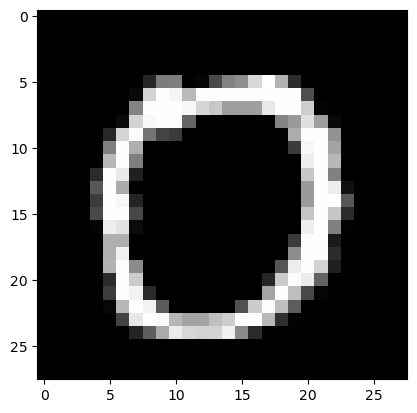

In [35]:
img = train_loader.dataset[0][0]

plt.imshow(img.numpy()[0,:,:], cmap='gray')

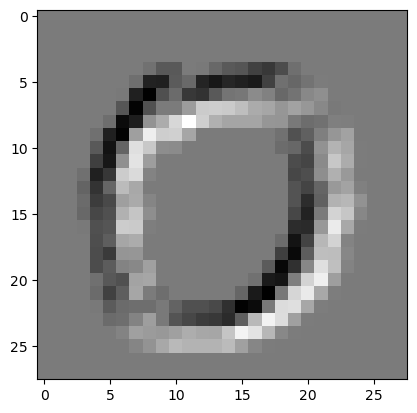

In [36]:
test_conv = ConvolutionalLayerGPU(1, 1, 3, 1)

kernel = np.zeros((1,3,3))
kernel[0,1,0] = 1
kernel[0,0,1] = 1

kernel[0,2,1] = -1
kernel[0,1,2] = -1

test_conv.W.value = cp.asarray(kernel)
test_conv.B.value = cp.asarray(np.zeros((1,1)))

input = img[0][None, None, :, :]

res = test_conv.forward(cp.asarray(input))

plt.imshow(res[0, 0,:,:], cmap='gray')

In [37]:
from torch import nn

np.random.seed(33)
torch.manual_seed(33)

batch_size = 2
in_channels = 3
out_channels = 4
kernel_size = 3
padding = 1
input_size = 8

X_np = np.random.randn(batch_size, in_channels, input_size, input_size).astype(np.float32)
X_torch = torch.from_numpy(X_np).requires_grad_(True)

conv = ConvolutionalLayerGPU(
    in_channels=in_channels,
    out_channels=out_channels,
    filter_size=kernel_size,
    padding=padding
)

torch_conv = nn.Conv2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    padding=padding,
    bias=True
)

with torch.no_grad():
    w = conv.W.value.get() if isinstance(conv.W.value, cp.ndarray) else conv.W.value
    torch_conv.weight.data = torch.from_numpy(
        w.transpose(3, 2, 0, 1)
    ).float()

    b = conv.B.value.get() if isinstance(conv.B.value, cp.ndarray) else conv.B.value
    torch_conv.bias.data = torch.from_numpy(b).float()

# ========== Forward Pass Test ==========
conv_forward = conv.forward(X_np)
conv_forward = conv_forward.get() if isinstance(conv_forward, cp.ndarray) else conv_forward

torch_forward = torch_conv(X_torch)

# Compare forward outputs
forward_diff = np.abs(conv_forward - torch_forward.detach().numpy()).max()
print(f"Forward pass max difference: {forward_diff:.2e}")
assert forward_diff < 1e-5, "Forward pass mismatch!"

# ========== Backward Pass Test ==========
# Create dummy gradient
grad_output = np.ones_like(conv_forward)
grad_output_torch = torch.from_numpy(grad_output).float()

# Your backward pass
your_input_grad = conv_forward.backward(grad_output)
your_input_grad = your_input_grad.get() if isinstance(your_input_grad, cp.ndarray) else your_input_grad

# PyTorch backward pass
torch_forward.backward(grad_output_torch)

# Compare weight gradients (transpose to match formats)
conv_dW = conv.W.grad.get() if isinstance(conv.W.grad, cp.ndarray) else conv.W.grad
torch_dW = torch_conv.weight.grad.numpy().transpose(2, 3, 1, 0)  # Convert to your format

weight_grad_diff = np.abs(conv_dW - torch_dW).max()
print(f"Weight gradient max difference: {weight_grad_diff:.2e}")
assert weight_grad_diff < 1e-5, "Weight gradient mismatch!"

conv_db = conv.B.grad.get() if isinstance(conv.B.grad, cp.ndarray) else conv.B.grad
torch_db = torch_conv.bias.grad.numpy()

bias_grad_diff = np.abs(conv_db - torch_db).max()
print(f"Bias gradient max difference: {bias_grad_diff:.2e}")
assert bias_grad_diff < 1e-5, "Bias gradient mismatch!"

Forward pass max difference: 5.50e+00


AssertionError: Forward pass mismatch!

In [111]:
def train_model(model, train_loader, epochs, lr, clip_value=5.0):
    """
    Trains the model with detailed timing breakdown
    Returns: (loss_history, time_stats)
    """
    loss_history = []

    # Detect if we're using GPU layers
    use_gpu = any(isinstance(layer, ConvolutionalLayerGPU) for layer in model.layers)
    xp = cp if use_gpu else np

    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0

        for x, y in train_loader:

            # Data conversion and transfer
            if use_gpu:
                x = cp.asarray(x.numpy(), dtype=cp.float32)
                y = cp.asarray(y.numpy())
            else:
                x = x.numpy().astype(np.float32)
                y = y.numpy()
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Forward pass
            predictions = model.forward(x)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Loss computation
            loss, grad = softmax_with_cross_entropy(predictions, y)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Backward pass
            model.backward(grad)  # Removed .get() to keep on GPU if needed
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Gradient clipping
            if use_gpu:
                cp.cuda.Stream.null.synchronize()

            # Parameter update
            for param in model.params().values():
                param.value -= lr * param.grad
                # Reset gradients using appropriate array module
                param.grad = xp.zeros_like(param.grad)
            if use_gpu:
                cp.cuda.Stream.null.synchronize()


            epoch_loss += loss
            batch_count += 1

        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)

        print(f"Epoch Loss: {avg_loss:.4f}")

    return loss_history



model = Model([
    ConvolutionalLayerGPU(1, 16, 3, 1),  # (1, 28, 28) -> (16, 28, 28)
    ReLULayer(),
    MaxPoolingLayer(2, 2),  # (16, 28, 28) -> (16, 14, 14)

    # Conv Block 2: kernel_size=5
    ConvolutionalLayerGPU(16, 64, 5, 2),  # (16, 14, 14) -> (64, 14, 14)
    ReLULayer(),
    MaxPoolingLayer(2, 2),  # (64, 14, 14) -> (64, 7, 7)

    # Conv Block 3: kernel_size=8
    ConvolutionalLayerGPU(64, 128, 5, 3),  # (64, 9, 9) -> (128, 9, 9)
    ReLULayer(),
    MaxPoolingLayer(2, 2),  # (128, 7, 7) -> (128, 4, 4)

    # Classifier
    Flattener(),
    FullyConnectedLayer(128 * 4 * 4 , 10)
]
)

In [115]:
epochs = 50
learning_rate = 0.01

In [ ]:
loss_history1 = train_model(model, train_loader, epochs, learning_rate)

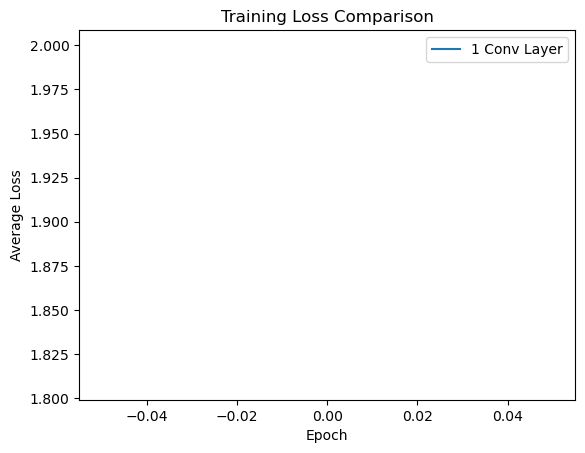

Final Loss for Model with 1 Conv Layer: 1.9038871438924343


In [114]:
losses = [item.get() for item in loss_history1]

plt.plot(losses, label="1 Conv Layer")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

print("Final Loss for Model with 1 Conv Layer:", losses[-1])


In [104]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

def eval_model(model, test_loader, classes=None, py_torch=False):
    """
    Evaluates a given model on a test set, printing key metrics and
    plotting a confusion matrix. You can pass an optional list of class
    names to label the axes of the confusion matrix.

    Parameters
    ----------
    model : nn.Module or similar
        The trained model to evaluate.
    test_loader : DataLoader
        A PyTorch DataLoader providing test batches (x, y).
    classes : list of str, optional
        List of class names for labeling the confusion matrix.
        If None, numeric labels are used.
    py_torch : bool, optional
        Indicates whether the model is a PyTorch model. If False,
        the model is assumed to be a NumPy-based model.
    Returns
    -------
    None
        Prints out accuracy, precision, recall, F1 score, classification
        report, and displays a confusion matrix heatmap.
    """
    if py_torch:
        model.eval()

    all_y_true = []
    all_y_pred = []

    # Iterate over the test set
    for x, y in test_loader:
        if py_torch:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

        # Forward pass
        y_hat = model.forward(x)

        if py_torch:
            # Move predictions and labels to CPU for metric computation
            preds = torch.argmax(y_hat, dim=1).detach().cpu().numpy()
            y = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        else:
            preds = np.argmax(y_hat, axis=1)
            # If y is a tensor, convert it to NumPy
            if isinstance(y, torch.Tensor):
                y = y.detach().cpu().numpy()

        # Now, y and preds should be NumPy arrays, so .astype works.
        all_y_true.extend(y.astype(int))
        all_y_pred.extend(preds.astype(int))

    # Convert to NumPy arrays
# Convert to NumPy arrays by converting each element explicitly if it is a Cupy array.
    all_y_true = np.array([elem.get() if isinstance(elem, cp.ndarray) else elem for elem in all_y_true])
    all_y_pred = np.array([elem.get() if isinstance(elem, cp.ndarray) else elem for elem in all_y_pred])


    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

    # Print key metrics
    print("\n\033[1mEvaluation Metrics:\033[0m")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Classification report
    print("\n\033[1mClassification Report:\033[0m")
    print(classification_report(all_y_true, all_y_pred, zero_division=0))

    # Confusion matrix and heatmap
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes if classes else None,
        yticklabels=classes if classes else None
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()



Evaluation Metrics:
Accuracy:  0.9310
Precision: 0.9321
Recall:    0.9310
F1 Score:  0.9310

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        87
           1       0.98      0.98      0.98       121
           2       0.92      0.91      0.92        94
           3       0.94      0.93      0.94        90
           4       0.88      0.92      0.90       101
           5       0.94      0.88      0.91        95
           6       0.92      0.96      0.94        97
           7       0.93      0.89      0.91        95
           8       0.95      0.89      0.92       114
           9       0.87      0.94      0.90       106

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



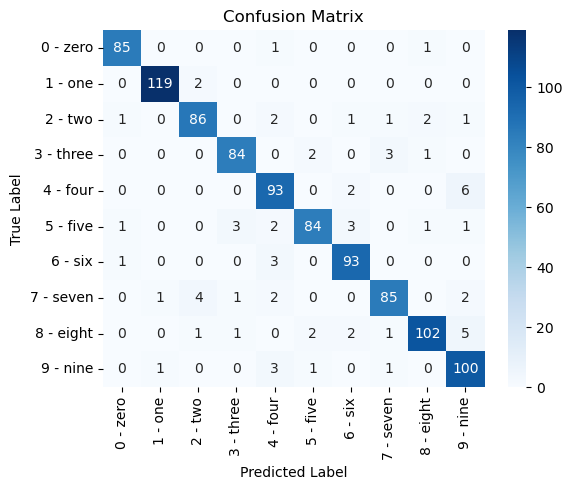

In [105]:
eval_model(model, test_loader, classes, py_torch=False)